# 1D CNN temporal analysis

Experimento de forecasting (predição) por meio de CNNs de 1 dimensão.

* Atividade PEL219 - GLWT MNIST - Gabriel Melo. Matrícula: 125.304-6

In [1]:
import numpy as np
import kagglehub
import pandas as pd

from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

/home/melo/coding/machine-learning/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-28 12:16:38.634455: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-28 12:16:38.675746: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-28 12:16:39.746892: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


# Forecasting with yahoo stocks
https://www.kaggle.com/datasets/arashnic/time-series-forecasting-with-yahoo-stock-price

In [2]:
# Download the forecasting dataset
path = kagglehub.dataset_download("arashnic/time-series-forecasting-with-yahoo-stock-price")
df = pd.read_csv(path + "/yahoo_stock.csv")
df

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107
...,...,...,...,...,...,...,...
1820,2020-11-16,3628.510010,3600.159912,3600.159912,3626.909912,5.281980e+09,3626.909912
1821,2020-11-17,3623.110107,3588.679932,3610.310059,3609.530029,4.799570e+09,3609.530029
1822,2020-11-18,3619.090088,3567.330078,3612.090088,3567.790039,5.274450e+09,3567.790039
1823,2020-11-19,3585.219971,3543.840088,3559.409912,3581.870117,4.347200e+09,3581.870117


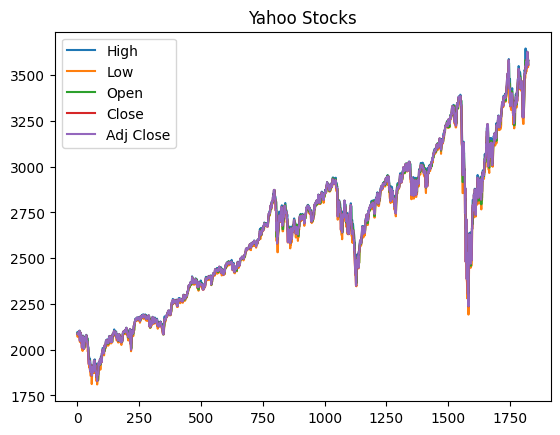

In [3]:
fig = plt.subplot(1,1,1)

for column, values in df.drop(columns=['Date', 'Volume']).items():
    fig.plot(values, label=column)
        
plt.title("Yahoo Stocks")
plt.legend()

plt.show()

In [ ]:
def create_sequences(data: np.array, seq_len: int = 5, forecast_len: int = 3):
    """
    create sequence of a original 1d series using a sliding window
    """
    X, y = [], []
    for i in range(len(data) - (seq_len + forecast_len)):
        seek = i+seq_len
        X.append(data[i:seek])
        y.append(data[seek:seek+forecast_len])
    return np.array(X), np.array(y)

In [5]:
X, y = create_sequences(df["Close"].values)

X.shape, y.shape

((1817, 5), (1817, 3))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.3)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1271, 5), (1271, 3), (546, 5), (546, 3))

In [7]:
def train_glwt(model: Sequential, X: np.array, Y: np.array, validation_data, optimizer="adam", loss="categorical_crossentropy", _epochs=10):
    histories = []
    
    for i in range(1, len(model.layers)):
        for layer in model.layers[:i]:
            layer.trainable = False
        for layer in model.layers[i:]:
            layer.trainable = True

        model.compile(optimizer, loss)
        
        histories.append(model.fit(x=X, y=Y, epochs=_epochs, validation_data=validation_data))
            
    return histories

In [8]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, strides=1, padding="causal", activation='relu', input_shape=(5,1)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=32, kernel_size=2, strides=1, padding="causal", activation='relu', input_shape=(2,1)))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(3))

model.summary()

/home/melo/coding/machine-learning/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-28 12:16:41.189115: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 5, 64)          │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 32)          │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,611 (18.01 KB)

 Trainable params: 4,611 (18.01 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
hist = train_glwt(model, X_train, y_train, (X_test, y_test), optimizer="adam", loss="mean_squared_error", _epochs=30)

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4019543.5000 - val_loss: 3741553.0000
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1082757.5000 - val_loss: 313400.2500
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 44717.6133 - val_loss: 8410.1719
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1655.3939 - val_loss: 7417.1621
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1355.6322 - val_loss: 7378.4458
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1351.6927 - val_loss: 7373.7603
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1350.1881 - val_loss: 7383.8184
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1351.3618 - val_loss: 7371.5811
Epoch 9/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1355.3929 - val_loss: 7384.2998
Epoch 10/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1353.8262 - val_loss: 7385.7363
Epoch 11/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1352.9116 - val_loss: 7371.1

## Testing

In [10]:
results = model.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [11]:
mae = mean_absolute_error(y_test, results)
mse = mean_squared_error(y_test, results)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - results) / y_test)) * 100  # MAPE is in percentage
r2 = r2_score(y_test, results)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"R2: {r2}")

MAE: 56.720610566191624
MSE: 7213.447994717349
RMSE: 84.93201984362169
MAPE: 1.9014841140728194%
R2: 0.8801354068640809


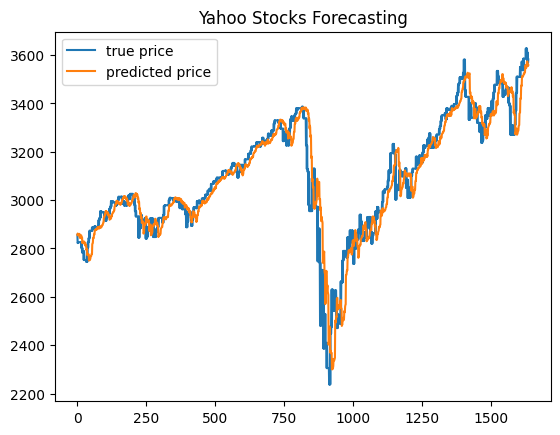

In [12]:
fig = plt.subplot(1,1,1)
fig.plot(y_test.flatten(), label="true price")
fig.plot(results.flatten(), label="predicted price")    
        
plt.title("Yahoo Stocks Forecasting")
plt.legend()

plt.show()

## Training data

In [13]:
hist = [h.history for h in hist]

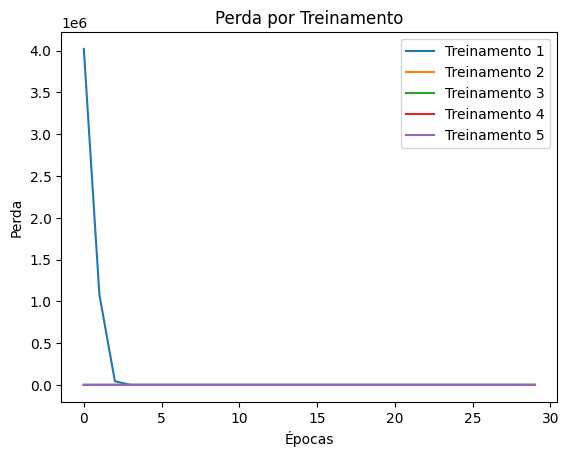

In [14]:
fig = plt.subplot(1,1,1)
for i, h in enumerate(hist):
    fig.plot(h['loss'], label=f'Treinamento {i+1}')
        
plt.title("Perda por Treinamento")
plt.xlabel("Épocas")
plt.ylabel("Perda")
plt.legend()

plt.show()